# Getting input from the serial ports using tkinter
First you need to make sure that pyserial and tkinter are installed on your system. On my mac (Sierra) I followed the approach below, opening a terminal window and running pip to install the libraries. We did the same thing on a Windows 10 machine with the same success. To open a terminal window, go to the Jupyter file browser and choose New/Terminal

pip install pyserial

pip install tkinter


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

import serial
import serial.tools.list_ports

import tkinter as tk
import tkinter.scrolledtext as scrolledtext
import tkinter.filedialog as filedialog

# Make a tkinter window
window = tk.Tk()
window.title("Rick's Serial Viewer / Logger")
window.geometry("800x800")

# with two scrolling text boxes
devList = scrolledtext.ScrolledText(window, highlightbackground = "orange", 
                                    highlightthickness = 2, 
                                    width = 60, height = 10)
devList.grid(row = 0, columnspan = 3,pady = 10,padx = 10)

serText = scrolledtext.ScrolledText(window, highlightbackground = "blue", 
                                    highlightthickness = 2, 
                                    width = 100, height = 40)
serText.grid(row = 1, columnspan = 4,padx = 10)

# and a frame with a dropdown and some buttons arranged on a grid
frame1 = tk.Frame(window)
tk.Label(frame1, text= "Select Serial Device Name:").grid(row = 0,column = 0, sticky = 'W')
devName = tk.StringVar()
devName.set("Choose a Serial Device")
devOption = tk.OptionMenu(frame1,devName,"Choose a Serial Device")
devOption.grid(row = 1, column = 0, columnspan = 2, sticky = 'W')
saveAsButton = tk.Button(frame1, text="Save Output As...")
saveAsButton.grid(row = 2, column=1)
startButton = tk.Button(frame1, text="Start Logging")
startButton.grid(row = 2, column=0)
clearButton = tk.Button(frame1, text="Clear the Output")
clearButton.grid(row = 3, column = 1)
frame1.grid(row = 0, column = 3)

ser = 0    # the serial port handle to read from if one is open, otherwise 0

def startLog(event):   # when the start logging button is pressed
    global ser
    if(startButton['text'] == "Start Logging"):
        print("starting tracking/logging")
        try:
            ser = serial.Serial(devName.get(),115200,timeout=1)
        except:
            ser = 0
            tk.messagebox.showerror("Opening Error", "Error opening serial device\nChoose a valid device")
        else:
            startButton.config(text = "Stop Logging")
    else:
        print("stopping tracking/logging")
        startButton.config(text = "Start Logging")
        try:   
            ser.close()
        except:   # I don't think this will ever happen
            tk.messagebox.showerror("Closing Error", "Error closing serial device")
        ser = 0
    
startButton.bind("<Button-1>", startLog)

def saveAs(event):   #when hitting the save as button
    file = tk.filedialog.asksaveasfile(mode='w')
    if(file):
        print("writing file...")
        file.write(serText.get("1.0",tk.END))
        file.close

saveAsButton.bind("<Button-1>", saveAs)

a = []                 # a place to save the data for later
def clearLog(event):   # when hitting the clear the output button
    global a
    a = []
    serText.delete("1.0",tk.END)

clearButton.bind("<Button-1>", clearLog)

def pollSerial():   # check for new lines on the serial port
    if(ser != 0):
        line = ser.readline().decode("utf-8")  # decode turns bytes into a string
        line = line.strip()                    # strip to remove potential \r\n double termination
        if(line != ""):                        # timeout will return a null line
            a.append(line.split(','))
            serText.insert(tk.END,line) 
            serText.insert(tk.END,'\n')        # add single \n to terminate line
            serText.yview_moveto(1.0)          # keep the focus at the end of the text
            window.after(1,pollSerial)         # return very often for more serial data if there was no timeout
        else:
            window.after(50,pollSerial)        # return often for more serial data
    else:                                      # return too often and the app locks in timeouts for slow data
        window.after(50,pollSerial)            # return often for more serial data
    
pollSerial()   # start it running repeatedly

def refreshPorts():
    # Show a list of existing serial ports so you can decide what to open
    ports = list(serial.tools.list_ports.comports())
    devOption['menu'].delete(0,'end')    # remove all the old options from the optionmenu
    devList.delete("1.0",tk.END)         # empty out the displayed list
    devList.insert(tk.END,"System returns this list of Serial Devices:\n\n")
    maxwidth = 0                         # track the largest menu option text width
    for p in ports:
        s = str(p).split()[0]            # put only the first token in the menu
        devOption['menu'].add_command(label=s, command=tk._setit(devName, s))
        maxwidth = max(maxwidth,len(s))
        devList.insert(tk.END,p)         # add the complete port line with descriptors to the list
        devList.insert(tk.END,'\n')      # with a new line
    devOption.config(width = maxwidth)   # make sure the menu is wide enough
    window.after(500,refreshPorts)       #repeat again later, but not too often   
        
refreshPorts()   # start it running repeatedly

window.mainloop()


starting tracking/logging
stopping tracking/logging


## Plot the Results

a[] is an array of all the lines recorded since the last clearing of the output, split at commas into string tokens. If all of those tokens are string representations of numbers, it will be very easy to convert them to a floating point array and draw somw graphs.

[['330.987', '   4.0999', '  -0.4354'], ['330.988', '   4.0994', '  -0.4344'], ['330.990', '   4.0988', '  -0.4333']] 


[[330.987    4.0999  -0.4354]
 [330.988    4.0994  -0.4344]
 [330.99     4.0988  -0.4333]]


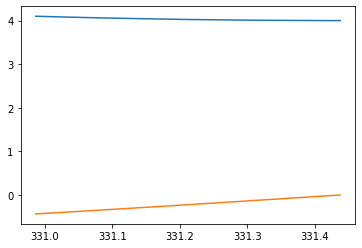

In [32]:
print(a[:3],"\n\n")                            # a should be full of string tokens
x = np.asfarray(a)                             # convert a[] into an np.array of floats
print(x[:3,:])                                 # print a few lines to be sure it worked  
plt.plot(x[:,0],x[:,1],x[:,0],x[:,2])